In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
from keras.datasets import mnist

In [13]:
(Xtr, Ltr), (X_test, L_test)=mnist.load_data()

In [14]:
Xtr.shape

(60000, 28, 28)

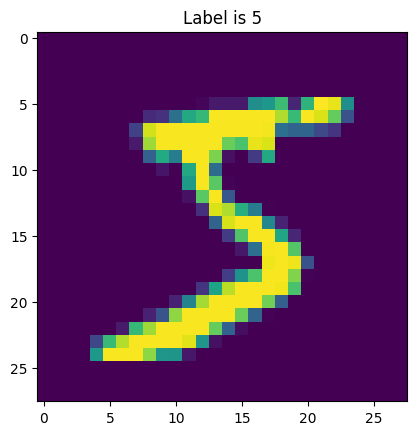

In [15]:
Image=Xtr[0,:,:]
Label=Ltr[0]


plt.title('Label is {Label}'.format(Label=Label))
plt.imshow(Image)

plt.show()
plt.close()


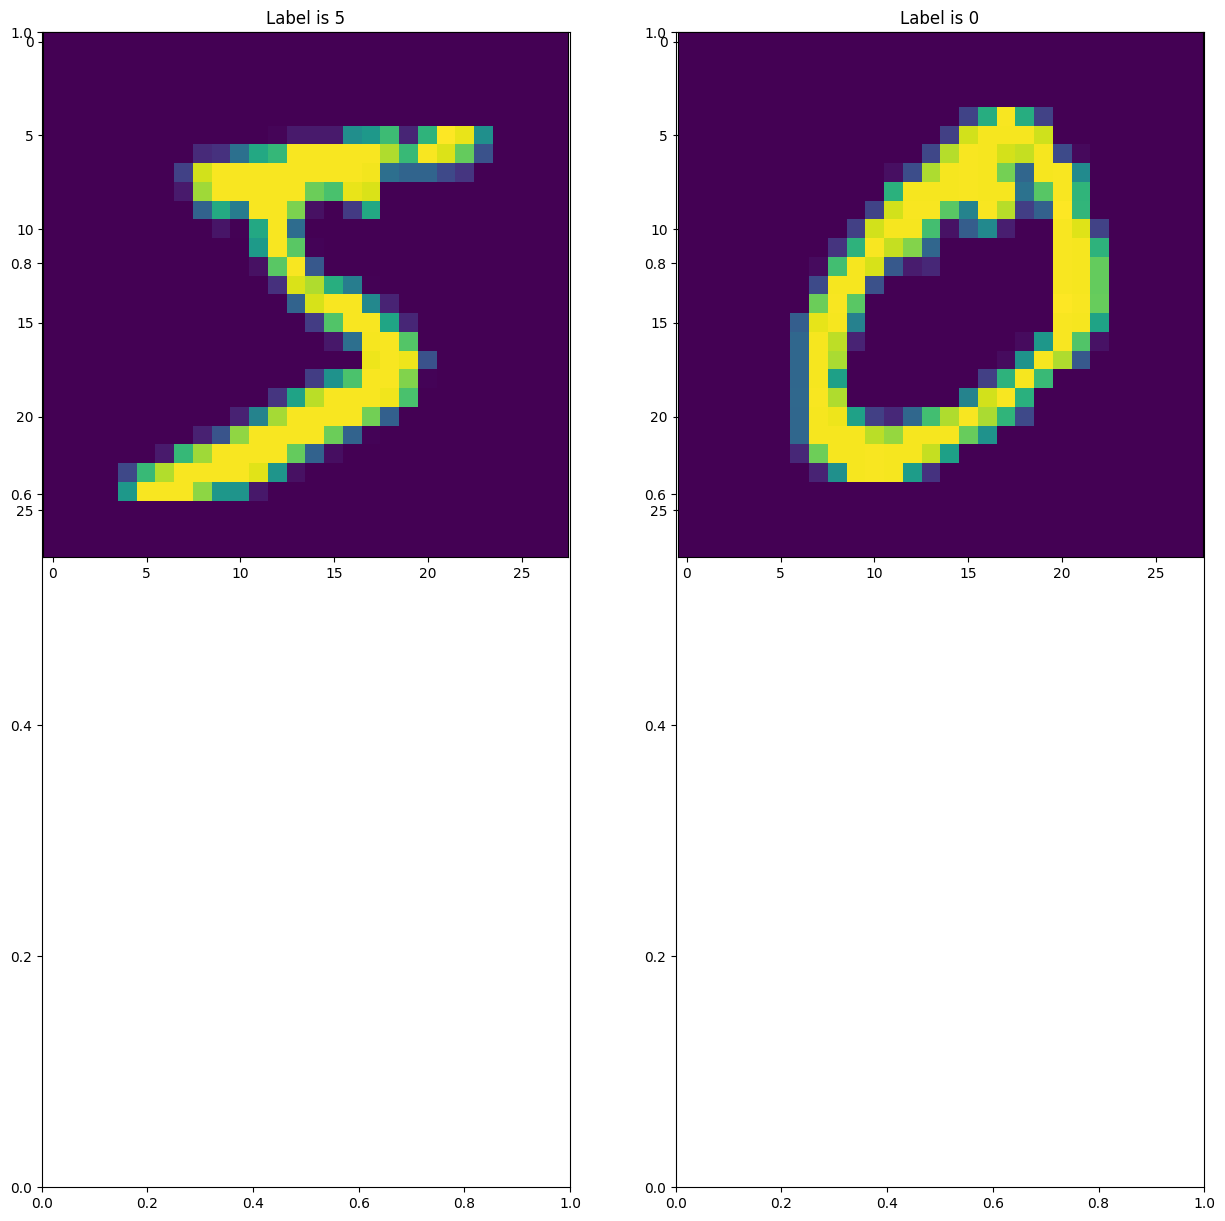

In [16]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(2,2,1)
ax1=plt.subplot(2,2,2)

Image=Xtr[0,:,:]
Label=Ltr[0]
Image1=Xtr[1,:,:]
Label1=Ltr[1]


ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(Image)
ax1.set_title('Label is {Label}'.format(Label=Label1))
ax1.imshow(Image1)


plt.show()
plt.close()


In [17]:
28*28

784

In [41]:
#Traing phase
num_sample=500
Tr_set=Xtr[:num_sample,:,:]
Ltr_set=Ltr[:num_sample]

Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2])

#Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2]).astype()
Tr_set.shape

(500, 784)

In [69]:
def predict(X):
    num_test=X.shape[0]

    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    Xfloat = X.astype(np.float32, copy=False)
    Trfloat = Tr_set.astype(np.float32, copy=False)

    for i in range(num_test):
        #distances=np.sum(np.abs(Tr_set-X[i,:]),axis=1)
        distances=np.sqrt(np.sum((Trfloat-Xfloat[i,:])**2,axis=1))
        
        min_index= np.argmin(distances)
        Lpred[i]=Ltr_set[min_index]
    return Lpred

In [99]:
def predict_KNN(X,k = 5):
    num_test=X.shape[0]
 
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    Xfloat = X.astype(np.float32, copy=False)
    Trfloat = Tr_set.astype(np.float32, copy=False)

    for i in range(num_test):
        #distances=np.sum(np.abs(Tr_set-X[i,:]),axis=1)
        distances=np.sqrt(np.sum((Trfloat-Xfloat[i,:])**2,axis=1))
        k_min_indexes = np.argsort(distances)[:k]
        votes = {}
        for index in k_min_indexes:
            label = Ltr_set[index]
            if label in votes:
                votes[label] += 1
            else:
                votes[label] = 1
        Lpred[i] = max(votes, key=votes.get)
            
        
    return Lpred

In [100]:
Test_images=X_test.reshape(X_test.shape[0],X_test.shape[1]* X_test.shape[2])
Labels_predicted=predict(Test_images)
Labels_predicted_KNN=predict_KNN(Test_images, k=3)

print("Accuracy:", np.mean(Labels_predicted==L_test))

print("Accuracy KNN:", np.mean(Labels_predicted_KNN==L_test))

Accuracy: 0.8294
Accuracy KNN: 0.8189


In [101]:
def mse_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

def mae_distance(a, b):
    return np.sum(np.abs(a - b), axis=1)

def predict_KNN(Xtest, Xtrain, Ltrain, distanceFunction, k=5):
    num_test = Xtest.shape[0]
    Lpred = np.zeros(num_test, dtype=Ltrain.dtype)
    
    Xtest = Xtest.astype(np.float32, copy=False)
    Xtrain = Xtrain.astype(np.float32, copy=False)

    for i in range(num_test):
        distances = distanceFunction(Xtrain, Xtest[i, :])
        k_min_indexes = np.argsort(distances)[:k]
        
        votes = {}
        for idx in k_min_indexes:
            label = Ltrain[idx]
            if label in votes:
                votes[label] += 1
            else:
                votes[label] = 1
        Lpred[i] = max(votes, key=votes.get)

    return Lpred


def KFolds_CrossValidation(X, L, distanceFunction, possible_K=[1,2,3,4,5], num_folds=3):
    n = X.shape[0]
    index = np.arange(n)
    np.random.shuffle(index)
    fold_size = n // num_folds

    accuracies = {K: [] for K in possible_K}

    for fold in range(num_folds):
        start = fold * fold_size
        end = start + fold_size

        test_idx = index[start:end]
        train_idx = np.concatenate((index[:start], index[end:]))

        X_train = X[train_idx]
        L_train = L[train_idx]
        X_test = X[test_idx]
        L_test = L[test_idx]

        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)

        for current_k in possible_K:
            L_pred = predict_KNN(X_test_flat, X_train_flat, L_train, distanceFunction, k=current_k)
            acc = np.mean(L_pred == L_test)
            accuracies[current_k].append(acc)

    avg_acc = {K: np.mean(v) for K, v in accuracies.items()}
    best_K = max(avg_acc, key=avg_acc.get)

    return best_K, avg_acc[best_K]
        
best_K, best_accuracy = KFolds_CrossValidation(Tr_set, Ltr_set, mse_distance)
print(f"Best K: {best_K}")
print(f"Best Accuracy: {best_accuracy}")


Best K: 3
Best Accuracy: 0.8634538152610443


In [102]:
accuracy = predict_KNN(Test_images, Tr_set, Ltr_set, mse_distance, k=best_K)
print("Final Accuracy with best K:", np.mean(accuracy==L_test))


Final Accuracy with best K: 0.8189
